In [ ]:
"""
burgers_equation.ipynb

Created on Sun Feb 26 2023

@authors: Luca d'Amico-Wong, Lukas Fesser, and Richard Qiu

This file contains code to reproduce and extend the results on the 1D Burgers equation presented in 
"DPM - A Novel Training Method for Physics-Informed Neural Networks in Extrapolation" (2021)
"""

'\nburgers_equation.ipynb\n\nCreated on Sun Feb 26 2023\n\n@authors: Luca d\'Amico-Wong, Lukas Fesser, and Richard Qiu\n\nThis file contains code to reproduce and extend the results on the 1D Burgers equation presented in \n"DPM - A Novel Training Method for Physics-Informed Neural Networks in Extrapolation" (2021)\n'

For a given field $u(x, t)$, the viscous Burger's equation is given by $$\frac{\delta u}{\delta t} + u\frac{\delta u}{\delta x} = \nu \frac{\delta^2 u}{\delta x^2}$$
Here, we consider $x \in [-1, 1]$ and $t \in [0, 0.5]$. We use the Dirichley boundary conditions and initial conditions
$$ u(-1, t) = u(1, t) = 0 \text{ , } u(x, 0) = -\sin(\pi x)$$
We train an MLP with tanh activation with the Burger's equation as part of the loss function and compare its accuracy in an intrapolation and extrapolation setting.

In [ ]:
# install deepxde

%pip install deepxde

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.7/150.7 KB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 14.6 MB/s eta 0:00:00


In [ ]:
# import packages

import deepxde as dde

import numpy as np

import torch

import matplotlib.pyplot as plt

if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.FloatTensor)

DeepXDE backend not selected or invalid. Use tensorflow.compat.v1.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Instructions for updating:
non-resource variables are not supported in the long term


Enable just-in-time compilation with XLA.



In [ ]:
torch.cuda.is_available()

device = torch.device("cuda")

In [ ]:
# define the PDE

def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx

In [ ]:
# define a computational geometry and a time domain

geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.5)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [ ]:
# define the boundary and initial conditions

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)

In [ ]:
# define the time PDE problem

data = dde.data.TimePDE(geomtime, pde, [bc, ic],
                        num_domain=25400, num_boundary=80, num_initial=160)

In [ ]:
# choose the network architecture and the training method

net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

model.compile("adam", lr=1e-3, loss_weights=[1, 1, 1])

Compiling model...
Building feed-forward neural network...
'build' took 0.057192 s

'compile' took 0.542331 s



In [ ]:
# train the model

losshistory, train_state = model.train(iterations=500)

Training model...

Step      Train loss                        Test loss                         Test metric
1500      [2.22e-02, 1.34e-03, 4.03e-02]    [2.22e-02, 1.34e-03, 4.03e-02]    []  
2000      [1.53e-02, 4.71e-04, 3.01e-02]    [1.53e-02, 4.71e-04, 3.01e-02]    []  

Best model at step 2000:
  train loss: 4.59e-02
  test loss: 4.59e-02
  test metric: []

'train' took 1.951083 s



Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


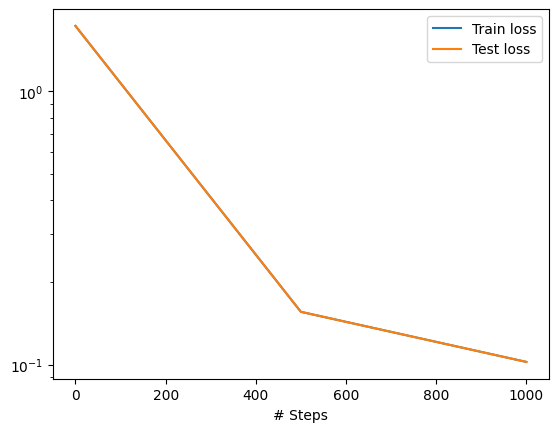

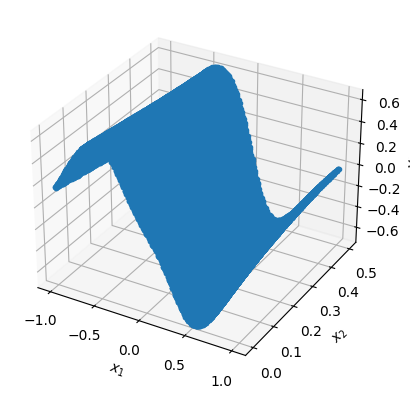

In [ ]:
# plot the loss function for the governing equation

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
# import data for the true solution

def gen_testdata():
    data = np.load("/content/Burgers.npz")
    t, x, exact = data["t"], data["x"], data["usol"].T
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    return X, y

In [ ]:
# compare the true solution with the predicted solution

X, y_true = gen_testdata()
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))

Mean residual: 0.47384852
L2 relative error: 0.36359299937817235


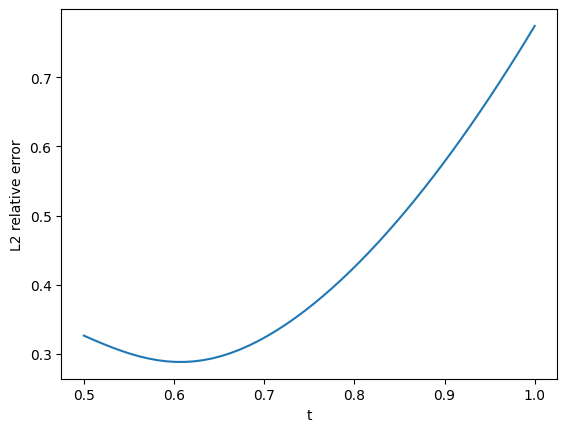

In [ ]:
# compute the L2 relative error between the true solution and the predicted solution

rel_l2_errors = []

for i in range(12800, 25600, 256):
    y_pred = model.predict(X[i:i+256])
    y_sol = y_true[i:i+256]

    # collect the relative L2 errors in a list
    rel_l2_errors.append(dde.metrics.l2_relative_error(y_sol, y_pred))


# plot the relative L2 errors

x = np.linspace(0.5, 1, 50)
plt.plot(x, rel_l2_errors)
plt.xlabel("t")
plt.ylabel("L2 relative error")
plt.show()

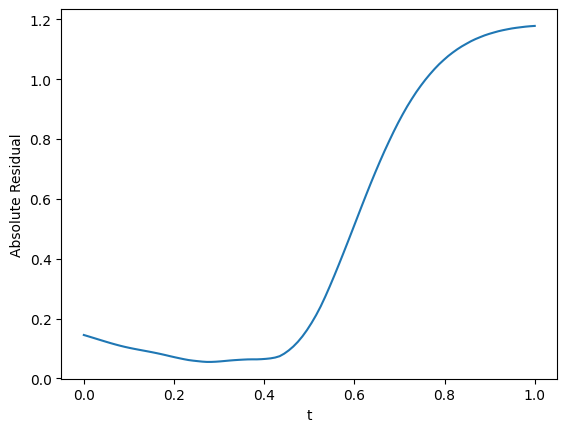

In [ ]:
# compute the L2 relative error between the true solution and the predicted solution

absolute_residual = []

for i in range(0, 25600, 256):
    absolute_residual.append(np.mean(np.absolute(f)[i:i+256]))


# plot the relative L2 errors

x = np.linspace(0, 0.01 * 100, 100)
plt.plot(x, absolute_residual)
plt.xlabel("t")
plt.ylabel("Absolute Residual")
plt.show()

Note that we only trained with $t \in [0, 0.5]$, for which the error is generally low. As soon as we enter an extrapolation setting ($t \in [0.5, 1]$), the error seems to increase linearly (?) in $t$. We tried this for several architectures and learning rates, but always observe the same general trend.

The below plots visualize this increase in the L2-error further. Note that the first to plots are in an intrapolation setting ($t = 0$ and $t = 0.5$), while the last three plots are outside of the training domain ($t = \{0.6, 0.7, 1\}$).

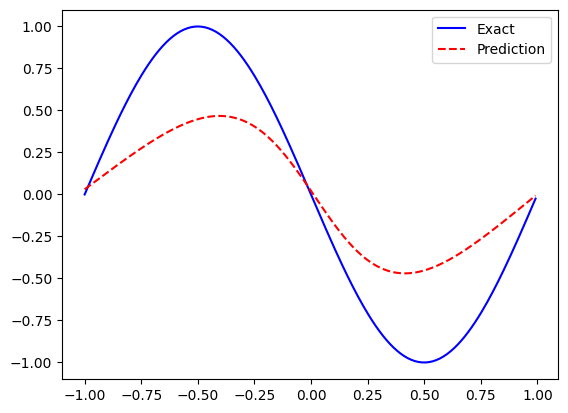

In [ ]:
# plot the true solution and the predicted solution in interpolation

import matplotlib.pyplot as plt

plt.figure()
plt.plot(X[:, 0][:255], y_true[:255], "b-", label="Exact")
plt.plot(X[:, 0][:255], y_pred[:255], "r--", label="Prediction")
plt.legend()
plt.show()

ValueError: ignored

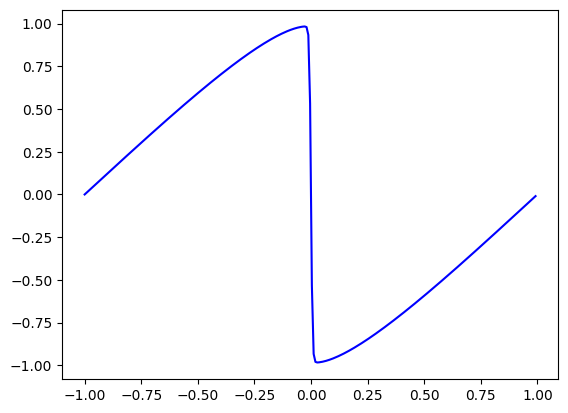

In [ ]:
# plot the true solution and the predicted solution between interpolation and extrapolation

plt.figure()
plt.plot(X[:, 0][12800:13055], y_true[12800:13055], "b-", label="Exact")
plt.plot(X[:, 0][12800:13055], y_pred[12800:13055], "r--", label="Prediction")
plt.legend()
plt.show()

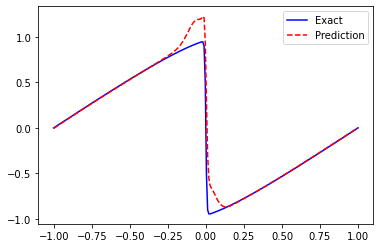

In [ ]:
# plot the true solution and the predicted solution between interpolation and extrapolation

plt.figure()
plt.plot(X[:, 0][15360:15616], y_true[15360:15616], "b-", label="Exact")
plt.plot(X[:, 0][15360:15616], y_pred[15360:15616], "r--", label="Prediction")
plt.legend()
plt.show()

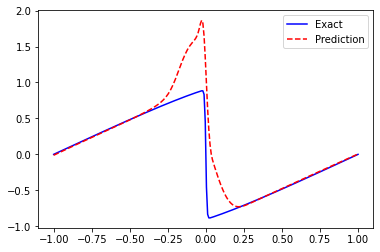

In [ ]:
# plot the true solution and the predicted solution between interpolation and extrapolation

plt.figure()
plt.plot(X[:, 0][17920:18176], y_true[17920:18176], "b-", label="Exact")
plt.plot(X[:, 0][17920:18176], y_pred[17920:18176], "r--", label="Prediction")
plt.legend()
plt.show()

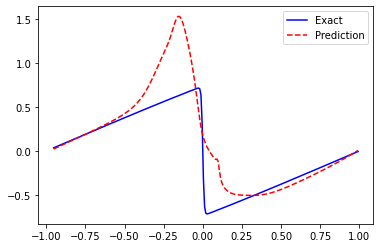

In [ ]:
# plot the true solution and the predicted solution in extrapolation

plt.figure()
plt.plot(X[:, 0][25350:25599], y_true[25350:25599], "b-", label="Exact")
plt.plot(X[:, 0][25350:25599], y_pred[25350:25599], "r--", label="Prediction")
plt.legend()
plt.show()